LSTM
==

In [1]:
from random import shuffle

import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
filename= '../data/french_clean.txt'

In [3]:
def reverse_sequence(nouns):
    return [noun[::-1] for noun in nouns]

def pad_sequence(sequence,pad_size,pad_token):
    # returns a list of the characters in the sequence with additional pad tokens to match pad_size if needed
    return list(sequence) + [pad_token] * (pad_size - len(sequence))

def code_sequence(charseq,encodingmap,unk_token='<unk>'):
    # charseq is a sequence of chars
    return [encodingmap[char] if char in encodingmap 
            else encodingmap[unk_token] for char in charseq]

def decode_sequence(idxseq,decodingmap):
    # idxseq is a list of integers
    return [decodingmap[idx] for idx in idxseq]

In [4]:
def read_data(filename, reverse_nouns=False):
    with open(filename, 'r', encoding='utf-8') as file:
        data = [line.strip() for line in file.readlines()]

    X, y = [], []
    for pair in data:
        noun, gender = pair.split(', ')
        if reverse_nouns:
            noun = reverse_sequence(noun)
        X.append(noun)
        y.append(gender)
    
    return X, y

In [5]:
def vocabulary(filename, labels=False, pad_token='<pad>', unk_token='<unk>'):
    
    nouns, genders = read_data(filename, reverse_nouns=False)
    
    if labels:
        sym2idx = {sym: idx for idx, sym in enumerate(set(genders))}
    else:
        noun_chars = set(char for noun in nouns for char in noun) # split the nouns into characters
        sym2idx = {sym: idx for idx, sym in enumerate(noun_chars)}
        sym2idx[unk_token] = len(sym2idx)
        sym2idx[pad_token] = len(sym2idx)

    idx2sym = {idx: sym for sym, idx in sym2idx.items()}

    return idx2sym, sym2idx

In [6]:
# Inspiration from code by Benoit Crabbé
class DataGenerator:

      def __init__(self, filename, reverse_nouns=False, pad_token='<pad>', unk_token='<unk>'):

          self.pad_token = pad_token
          self.unk_token = unk_token

          self.input_idx2sym,self.input_sym2idx   = vocabulary(filename,False)
          self.output_idx2sym,self.output_sym2idx = vocabulary(filename,True)

          nouns, genders = read_data(filename, reverse_nouns=reverse_nouns)
          self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(nouns, genders, test_size=0.2)

      def generate_batches(self,batch_size,validation=False):

          if validation:
              X = self.X_test
              y = self.y_test
          else:
              X = self.X_train
              y = self.y_train

          assert(len(X) == len(y))

          N     = len(X)
          idxes = list(range(N))

          # Data ordering
          shuffle(idxes)
          idxes.sort(key=lambda idx: len(X[idx]))

          # batch generation
          bstart = 0
          while bstart < N:
              bend        = min(bstart+batch_size,N)
              batch_idxes = idxes[bstart:bend]
              batch_len   = max(len(X[idx]) for idx in batch_idxes)
              Xpad        = [pad_sequence(X[idx],batch_len,self.pad_token) for idx in batch_idxes]
              seqX        = [code_sequence(x,self.input_sym2idx,self.unk_token) for x in Xpad]
              seqY        = [self.output_sym2idx[y[idx]] for idx in batch_idxes]

              assert(len(seqX) == len(seqY))
              yield (seqX,seqY)
              bstart += batch_size

Model
==

Train the model by feeding it words in reverse order (since we want to start from the end of the word) and the corresponding genders. The model will learn to predict the gender based on the characters seen so far.

Takes preprocessed words as input:
- tokenized into characters 
- each character mapped to a unique integer id (same with each gender)
- sequences should be padded so they all have the same length

In [74]:
class GenderLSTM(nn.Module):

    def __init__(self, datagenerator, embedding_dim, hidden_dim, device='cpu'):
        super(GenderLSTM, self).__init__()
        self.to(device)

        invocab_size = len(datagenerator.input_idx2sym)
        outvocab_size = len(datagenerator.output_idx2sym)

        self.device = torch.device(device)
        self.pad_idx = datagenerator.input_sym2idx[datagenerator.pad_token]
        self.embedding = nn.Embedding(invocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, outvocab_size)
        self.softmax = nn.Softmax(dim=-1)

        for param in self.parameters():
            param.requires_grad = True


    def forward(self, inputs):
        embeds = self.embedding(inputs)
        
        # lstm_out contains the hidden states for each time step in the input sequence for each element in the batch. Shape: [batch_size, sequence_length, hidden_size]
        # hidden is the hidden state for the last time step in the input sequence for each element in the batch. Shape: [num_layers(* num_directions which is 1 here), batch_size, hidden_size]
        lstm_out, (hidden, _) = self.lstm(embeds)   
        
        out_logits = self.fc(lstm_out)   # shape: [batch_size, sequence_length, num_classes] --> these will be used to get accuracy values for each time step
        
        #  taking the last hidden state of the last layer with hidden[-1]
        hidden_logits = self.fc(hidden[-1]) # shape: [batch_size, sequence_length]  --> these will be used for loss computation

        # add softmax to get probability distributions (for easier interpretability)
        out_probabilities = self.softmax(out_logits)   # probability distribution over the classes for each character in the sequence 
        # it would also be a good idea to calibrate the model (dividing c by a value T (tempreture) that is a hyperparameter that can be tuned --> ask Timothee)
        return out_probabilities, hidden_logits  


    def train_model(self, datagenerator, n_epochs, batch_size, learning_rate=0.001):
        criterion = nn.CrossEntropyLoss(ignore_index=self.pad_idx)
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        self.train_all_char_accuracies = [] # will contain the average accuracies of all character positions after each epoch (a list of lists)
        self.valid_all_char_accuracies = []
        
        self.train_max_indecies = []    # will contain the index of the character with the highest average accuracy after each epoch
        self.valid_max_indecies = []

        self.train_max_accuracies = []  # will contain the accuracy of the character with the highest average accuracy after each epoch
        self.valid_max_accuracies = []
        
        self.avg_train_losses = []
        self.avg_valid_losses = []
        
        for epoch in range(n_epochs):
            print(f'Epoch: {epoch}')
            epoch_train_accuracies = [] # will contain lists, each of length sequence_length, containing average accuracies for each character position in a batch of words. At the end, the lists will need to be padded to have the same length, converted to a matrix, and the average of each column computed as the overall average accuracy for each character position. The highest accuracy in the resulting list will show which character position is overall most predictive of gender.
            epoch_valid_accuracies = []
            epoch_train_losses = []
            epoch_valid_losses = []
            
            self.train()
            for inputs, labels in datagenerator.generate_batches(batch_size):
                X = torch.LongTensor(inputs).to(self.device)
                Y = torch.LongTensor(labels).to(self.device) # shape: [batch_size]

                optimizer.zero_grad()
                Y_seq_probs, Y_hidden_logits = self.forward(X)    # shapes: [batch_size, sequence_length, num_classes], [batch_size, num_classes]

                # batch_train_accuracies = []    # list to store the accurracies at each character position for all words in the batch. The index of each inner list will be the index of the character (the character position)

                # # loop over each character position of all the words in the batch
                # for char_position in range(Y_seq_probs.size(1)):                              # Y_log_probs.size(1) = sequence_length
                #     Y_char_position_log_probs = Y_seq_probs[:, char_position, :]              # Shape: [batch_size, num_classes]
                #     Y_char_position_pred = torch.argmax(Y_char_position_log_probs, dim=-1)    # Shape: [batch_size] --> contains predictions for all words in the batch, having seen all the characters up to and including the current position (or just the character at the current position?)
                    
                #     # compute accuracy for the current position
                #     correct = (Y_char_position_pred == Y)
                #     char_position_accuracy = float(torch.sum(correct)) / len(correct) # model accuracy over the full batch => having seen char_position many characters (or the character at the current position - I'm not sure which) what proportion of the words in the batch had their gender correctly predicted
                #     batch_train_accuracies.append(char_position_accuracy)

                # epoch_train_accuracies.append(batch_train_accuracies)

                # compute accuracies for all character positions
                Y_pred = torch.argmax(Y_seq_probs, dim=-1)  # shape: [batch_size, sequence_length]
                correct = (Y_pred == Y.unsqueeze(-1))
                char_position_accuracies = correct.float().mean(dim=0)  # accuracies for each character position. Shape: [batch_size]
                epoch_train_accuracies.append(char_position_accuracies.tolist())

                loss = criterion(Y_hidden_logits, Y)
                loss.backward()

                # Check gradients
                # for param in self.parameters():
                #     print(param.grad) # --> all output as None!

                optimizer.step()
                epoch_train_losses.append(loss.item())

            # pad the batch accuracy lists with 0s so they have the same lengths, and convert into a 2D pytorch tensor (matrix)
            max_length = max(len(l) for l in epoch_train_accuracies)
            padded_epoch_train_accuracies = torch.tensor([l + [0.0] * (max_length - len(l)) for l in epoch_train_accuracies])   # shape: [num_of_batches, max_sequence_length]
            
            # compute the average of each column as the overall average accuracy for each character position
            # dividing the sum of non-zero elements for each column by the total number of non-zero elements for that column
            mask = padded_epoch_train_accuracies != 0.0 # we don't want the padding to affect the average accuracy values
            avg_char_position_accuracies = (padded_epoch_train_accuracies * mask).sum(dim=0) / (mask).sum(dim=0)   # shape: [max_sequence_length]
            
            # dividing the sum of all elements (zero and non-zero) for each column by the total number of elements for that column
            # avg_char_position_accuracies = padded_epoch_train_accuracies.sum(dim=0) / len(padded_epoch_train_accuracies)   # shape: [max_sequence_length]
            
            self.train_all_char_accuracies.append(avg_char_position_accuracies)
            
            # The index with the highest accuracy is indicative of the overall most predictive position
            max_accuracy, max_index = avg_char_position_accuracies.max(dim=0)
            self.train_max_indecies.append(max_index)
            self.train_max_accuracies.append(max_accuracy)

            self.eval()
            for val_inputs, val_labels in datagenerator.generate_batches(batch_size, validation=True):
                with torch.no_grad():
                    X_val = torch.LongTensor(val_inputs).to(self.device)
                    Y_val = torch.LongTensor(val_labels).to(self.device)

                    Y_val_seq_probs, Y_val_hidden_logits = self.forward(X_val)
                    
                    # batch_valid_accuracies = []

                    # # loop over each character position of all the words in the batch
                    # for char_position in range(Y_val_seq_probs.size(1)):                              
                    #     Y_char_position_log_probs = Y_val_seq_probs[:, char_position, :]          # Shape: (batch_size, num_classes)
                    #     Y_char_position_pred = torch.argmax(Y_char_position_log_probs, dim=-1)    # Shape: (batch_size) --> contains predictions for all words in the batch, having seen all the characters up to and including the current position (or just the character at the current position?)
                        
                    #     # compute accuracy for the current position
                    #     correct = (Y_char_position_pred == Y_val)
                    #     char_position_accuracy = float(torch.sum(correct)) / len(correct) # model accuracy over the full batch => having seen char_position many characters (or the character at the current position - I'm not sure which) what proportion of the words in the batch had their gender correctly predicted
                    #     batch_valid_accuracies.append(char_position_accuracy)
                                        
                    # epoch_valid_accuracies.append(batch_valid_accuracies)

                    # compute accuracies for all character positions
                    Y_pred = torch.argmax(Y_val_seq_probs, dim=-1)  # shape: [batch_size, sequence_length]
                    correct = (Y_pred == Y_val.unsqueeze(-1))
                    char_position_accuracies = correct.float().mean(dim=0)  # accuracies for each character position. Shape: [batch_size]
                    epoch_valid_accuracies.append(char_position_accuracies.tolist())

                    loss = criterion(Y_val_hidden_logits, Y_val)
                    epoch_valid_losses.append(loss.item())

            # pad the batch accuracy lists with 0s so they have the same lengths, and convert into a 2D pytorch tensor (matrix)
            max_length = max(len(l) for l in epoch_valid_accuracies)
            padded_epoch_valid_accuracies = torch.tensor([l + [0.0] * (max_length - len(l)) for l in epoch_valid_accuracies])   # shape: [num_of_batches, max_sequence_length]
                    
            # compute the average of each column as the overall average accuracy for each character position
            # while masking out 0s
            mask = padded_epoch_valid_accuracies != 0.0
            avg_char_position_accuracies = (padded_epoch_valid_accuracies * mask).sum(dim=0) / mask.sum(dim=0)    # shape: [max_sequence_length]
            
            # while keeping 0s
            # avg_char_position_accuracies = padded_epoch_valid_accuracies.sum(dim=0) / len(padded_epoch_valid_accuracies)    # shape: [max_sequence_length]
            
            self.valid_all_char_accuracies.append(avg_char_position_accuracies)
                    
            # The index with the highest accuracy is indicative of the overall most predictive position
            max_accuracy, max_index = avg_char_position_accuracies.max(dim=0)
            self.valid_max_indecies.append(max_index)
            self.valid_max_accuracies.append(max_accuracy)


            # store & report metrics at the end of each epoch
            avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
            avg_valid_loss = sum(epoch_valid_losses) / len(epoch_valid_losses)
            self.avg_train_losses.append(avg_train_loss)
            self.avg_valid_losses.append(avg_valid_loss)

            print(f'[Train] Loss: {avg_train_loss * 100:.2f}%   Max Accuracy: {self.train_max_accuracies[-1] * 100:.2f}%   Index: {self.train_max_indecies[-1]}')      
            print(f'[Valid] Loss: {avg_valid_loss * 100:.2f}%   Max Accuracy: {self.valid_max_accuracies[-1] * 100:.2f}%   Index: {self.valid_max_indecies[-1]}')
            print('-' * 100)


    def predict(self, datagenerator, batch_size):
        # TODO
        ...


In [75]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 64
hidden_size = 128
n_epochs = 10
batch_size = 32

data_generator = DataGenerator(filename, reverse_nouns=True)
model = GenderLSTM(data_generator, embedding_dim, hidden_size, device=DEVICE)
model.train_model(data_generator, n_epochs, batch_size)

Epoch: 0
[Train] Loss: 30.01%   Max Accuracy: 92.86%   Index: 23
[Valid] Loss: 33.87%   Max Accuracy: 91.67%   Index: 23
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 27.21%   Max Accuracy: 89.29%   Index: 21
[Valid] Loss: 32.08%   Max Accuracy: 87.50%   Index: 19
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 25.84%   Max Accuracy: 96.43%   Index: 28
[Valid] Loss: 32.02%   Max Accuracy: 95.83%   Index: 23
----------------------------------------------------------------------------------------------------
Epoch: 3
[Train] Loss: 24.60%   Max Accuracy: 92.86%   Index: 28
[Valid] Loss: 31.35%   Max Accuracy: 95.83%   Index: 23
----------------------------------------------------------------------------------------------------
Epoch: 4
[Train] Loss: 23.22%   Max Accuracy: 96.43%   Index: 28
[Valid] Loss: 31.50%   Max Accuracy: 95.83%   I

In [57]:
# toy example
x = torch.tensor([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], [1.0, 2.0, 3.0, 4.0, 5.0, 0.0, 0.0], [1.0, 2.0, 3.0, 4.0, 0.0, 0.0, 0.0]])

mask = x != 0.0

# dividing the sum of non-zero elements for each column by the total number of non-zero elements for each column
# mean = (x * mask).sum(dim=0) / mask.sum(dim=0)

# dividing the sum of all elements for each column by the total number of elements for each column (not excluding 0s)
mean = x.sum(dim=0) / len(x)

print(f'original tensor:\n{x}\n')
print(f'sum of the values in each column:\n{x.sum(dim=0)}\n')
print(f'number of words in the batch (batch_size): {len(x)}\n')
print(f'average character accuracy:\n{mean}')

original tensor:
tensor([[1., 2., 3., 4., 5., 6., 7.],
        [1., 2., 3., 4., 5., 0., 0.],
        [1., 2., 3., 4., 0., 0., 0.]])

sum of the values in each column:
tensor([ 3.,  6.,  9., 12., 10.,  6.,  7.])

number of words in the batch (batch_size): 3

average character accuracy:
tensor([1.0000, 2.0000, 3.0000, 4.0000, 3.3333, 2.0000, 2.3333])


In [65]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot2(train_acc, valid_acc, train_losses, valid_losses, train_max_indices, dev_max_indices):

    gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 

    fig = plt.figure(figsize=(10, 12))
    plt.subplots_adjust(hspace=0.5)

    ax1 = plt.subplot(gs[0])    # plot of accuracy
    ax2 = plt.subplot(gs[1])    # plot of loss
    ax3 = plt.subplot(gs[2])    # plot of indecies

    n_epochs = range(1, len(valid_losses) + 1)

    # Plot for accuracy
    ax1.set_title('Max Accuracy Evolution Over Epochs')
    ax1.plot(n_epochs, train_acc, marker='o', color='steelblue', label='Max Training Accuracy')
    ax1.plot(n_epochs, valid_acc, marker='o', color='orange', label='Max Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, linestyle='--')

    # Plot for loss
    ax2.set_title('Average Loss Evolution Over Epochs')
    ax2.plot(n_epochs, train_losses, marker='o', color='steelblue', label='Average Training Loss')
    ax2.plot(n_epochs, valid_losses, marker='o', color='orange', label='Average Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, linestyle='--')

    # Plot for max indices
    bar_width = 0.3
    ax3.set_title('Character position (index) with the highest average accuracy at each epoch')
    ax3.bar([i-bar_width/2 for i in n_epochs], train_max_indices, color='steelblue', width=bar_width, label='Training Set')
    ax3.bar([i+bar_width/2 for i in n_epochs], dev_max_indices, color='orange', width=bar_width, label='Validation Set')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Indices')
    ax3.legend()
    ax3.grid(True, linestyle='--')

    plt.show()

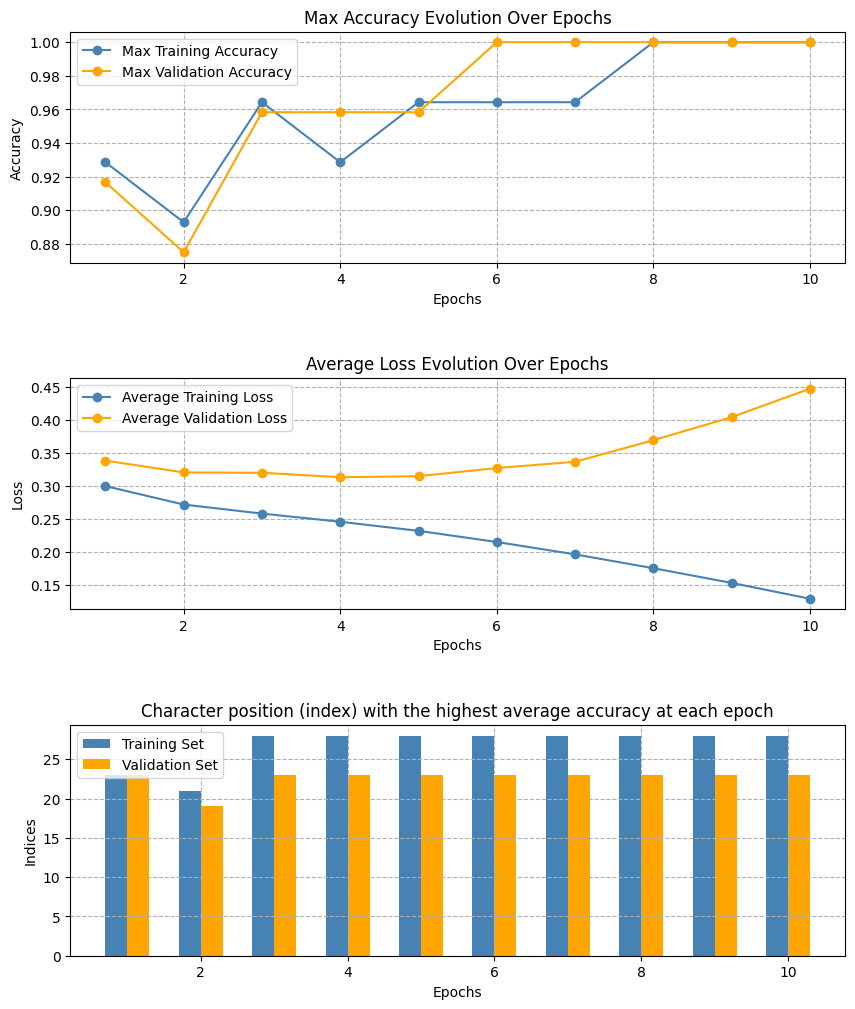

In [76]:
plot2(model.train_max_accuracies, model.valid_max_accuracies, model.avg_train_losses, model.avg_valid_losses, model.train_max_indecies, model.valid_max_indecies)

In [77]:
train_all_char_accuracies = [tensor.tolist() for tensor in model.train_all_char_accuracies]
train_char_accuracies = pd.DataFrame(train_all_char_accuracies).rename_axis('epochs')
train_char_accuracies

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
epochs,,,,,,,,,,,,,,,,,,,,,
0,0.553424,0.543016,0.562371,0.560352,0.549534,0.548806,0.553211,0.563982,0.573657,0.587099,...,0.892857,0.892857,0.928571,0.892857,0.892857,0.821429,0.678571,0.607143,0.500000,0.464286
1,0.551171,0.546481,0.562772,0.561509,0.556314,0.552479,0.558970,0.567344,0.575819,0.590339,...,0.892857,0.857143,0.821429,0.678571,0.678571,0.607143,0.571429,0.607143,0.607143,0.607143
2,0.551813,0.546620,0.562519,0.562757,0.554843,0.553632,0.560786,0.568085,0.577549,0.593088,...,0.892857,0.892857,0.928571,0.928571,0.928571,0.928571,0.928571,0.964286,0.964286,0.964286
3,0.551862,0.545186,0.562194,0.561835,0.554361,0.553989,0.560504,0.569590,0.577586,0.595526,...,0.857143,0.857143,0.892857,0.892857,0.892857,0.892857,0.892857,0.928571,0.892857,0.821429
4,0.550998,0.544292,0.560612,0.562135,0.555010,0.554234,0.559598,0.570623,0.578953,0.596940,...,0.892857,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.964286,0.964286,0.964286
5,0.548084,0.538846,0.559787,0.561113,0.555704,0.554079,0.559895,0.571429,0.581078,0.598676,...,0.892857,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.964286,0.964286,0.964286
6,0.544228,0.535937,0.559254,0.561351,0.556900,0.555730,0.561220,0.574562,0.582214,0.598104,...,0.892857,0.928571,0.928571,0.928571,0.928571,0.928571,0.928571,0.964286,0.964286,0.964286
7,0.538480,0.535205,0.558119,0.560037,0.556122,0.556247,0.562928,0.574574,0.587102,0.598616,...,0.892857,0.928571,0.928571,0.928571,0.964286,0.964286,0.964286,1.000000,1.000000,1.000000
8,0.525506,0.533001,0.556848,0.558666,0.555983,0.557481,0.566098,0.579027,0.586173,0.602488,...,0.892857,0.928571,0.964286,0.964286,0.964286,0.964286,0.964286,1.000000,1.000000,1.000000


In [78]:
valid_all_char_accuracies = [tensor.tolist() for tensor in model.valid_all_char_accuracies]
valid_char_accuracies = pd.DataFrame(valid_all_char_accuracies).rename_axis('epochs')
valid_char_accuracies

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
epochs,,,,,,,,,,,,,,,,,,,,,
0,0.540013,0.535755,0.562641,0.558505,0.559323,0.549817,0.554274,0.573291,0.578636,0.595760,...,0.726562,0.682292,0.864583,0.875000,0.875000,0.875000,0.875000,0.916667,0.875000,0.750000
1,0.547649,0.533010,0.561902,0.557042,0.557218,0.549499,0.555347,0.571581,0.578636,0.593567,...,0.723958,0.677083,0.864583,0.875000,0.833333,0.833333,0.833333,0.791667,0.500000,0.416667
2,0.547720,0.535473,0.564893,0.555151,0.558363,0.551765,0.557403,0.571421,0.579521,0.592562,...,0.729167,0.682292,0.880208,0.875000,0.875000,0.875000,0.916667,0.958333,0.958333,0.916667
3,0.547684,0.536071,0.567392,0.557684,0.561096,0.551248,0.559639,0.573023,0.579589,0.596308,...,0.734375,0.677083,0.880208,0.916667,0.875000,0.875000,0.916667,0.958333,0.916667,0.875000
4,0.547684,0.535438,0.564436,0.555900,0.560949,0.551765,0.557672,0.571261,0.577274,0.597771,...,0.739583,0.687500,0.880208,0.916667,0.916667,0.916667,0.916667,0.958333,0.958333,0.916667
5,0.547720,0.531285,0.563626,0.559396,0.558806,0.550056,0.558745,0.569177,0.580814,0.594390,...,0.736979,0.682292,0.880208,0.916667,0.916667,0.916667,0.958333,1.000000,1.000000,0.958333
6,0.547684,0.528822,0.565949,0.561501,0.559545,0.551089,0.560443,0.568803,0.581495,0.591831,...,0.742188,0.677083,0.880208,0.916667,0.916667,0.916667,0.958333,1.000000,1.000000,0.958333
7,0.537620,0.534523,0.564048,0.562143,0.559213,0.554310,0.558298,0.567201,0.581427,0.591283,...,0.744792,0.697917,0.880208,0.916667,0.916667,0.916667,0.958333,1.000000,1.000000,0.958333
8,0.537655,0.526675,0.562535,0.563428,0.559397,0.556218,0.560086,0.566346,0.582516,0.588176,...,0.736979,0.687500,0.880208,0.916667,0.916667,0.916667,0.958333,1.000000,1.000000,0.958333
